In [ ]:
import numpy as np
import torch
import torch.nn               as nn
import torch.distributions as tdist
import os
import sys
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.utils.spectral_norm as spectral_norm
from torch.utils.data         import Dataset, TensorDataset, DataLoader
from torchvision              import datasets
import time
from time import sleep
from tqdm import tqdm
from prettytable import PrettyTable

from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/NashFPNs/TransportationNetworks/')
save_dir = './drive/MyDrive/NashFPNs/' # generated data should be saved in this path

device = "cuda"

capacity   = torch.tensor
context    = torch.tensor
action     = torch.tensor
edge       = torch.tensor
inference  = torch.tensor 
context    = torch.tensor

seed = 42
torch.manual_seed(seed)

KeyboardInterrupt: ignored

## Load Training Data

In [ ]:
data_set = 'SiouxFalls'
save_dir = 'drive/MyDrive/NashFPNs/TrafficTrainingData/'
state_path = save_dir + data_set + '_training_data.pth'
state = torch.load(state_path)

In [ ]:
capacity        = state['capacity']
W               = state['W']
N               = state['N']
free_flow_time  = state['free_flow_time']
x_train         = state['x_train']
x_test          = state['x_test']
d_train         = state['d_train']
d_test          = state['d_test']
b               = state['origin_destination_pairs']

context_size    = d_train.shape[1]
n_train         = d_train.shape[0]
n_test          = d_test.shape[0]

n_ODpairs       = b.shape[1]
n_edges         = x_train.shape[1]
n_nodes         = b.shape[0]

In [ ]:
train_dataset   = TensorDataset(x_train, d_train)
test_dataset    = TensorDataset(x_test, d_test)

train_batch_size = 500
test_batch_size  = 500

train_loader  = DataLoader(dataset=train_dataset,  
                            batch_size=train_batch_size, shuffle=True) 
test_loader   = DataLoader(dataset=test_dataset,   
                            batch_size=test_batch_size,  shuffle=False) 

In [ ]:
print('n_ODpairs = ', n_ODpairs, 'n_nodes = ', n_nodes, ', n_edges = ', n_edges, ', n_train = ', x_train.shape[0])

n_ODpairs =  528 n_nodes =  24 , n_edges =  76 , n_train =  5000


## Create Neural Network Architecture

In [ ]:
inference = torch.tensor
latent_variable = torch.tensor
context = torch.tensor

class Traffix_Net(nn.Module):
    def __init__(self, N, b, context_size, alpha, device):
        super().__init__()
        
        self.b = b.to(device)
        self.alpha = alpha

        U,s,VT = torch.linalg.svd(N, full_matrices=False)
        ind = s >= 1e-5 
        s = s[ind]
        U = U[:,ind]
        VT = VT[ind, :]
        self.V = VT.t().to(device)
        self.V_Sinv_UT = VT.t().matmul( torch.diag(1/s).matmul(U.t()) ).to(device)

        self.n_nodes    = N.shape[0]
        self.n_edges    = N.shape[1] 
        self.n_ODpairs  = b.shape[1] 

        self.F_fcs_d = nn.ModuleList([nn.Linear(context_size, 100), 
                                    nn.Linear(100, 100),
                                    nn.Linear(100, self.n_edges)])
        self.fc_final_d = nn.Linear(self.n_edges, self.n_edges)

        self.F_fcs = nn.ModuleList([nn.Linear(self.n_edges, 100), 
                                    nn.Linear(100, self.n_edges)])
        self.fc_final = nn.Linear(self.n_edges, self.n_edges)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)

        self.tanh = nn.Tanh()

        for fc in self.F_fcs: 
          torch.nn.init.zeros_(fc.weight)
        for fc in self.F_fcs_d: 
          torch.nn.init.zeros_(fc.weight)

        torch.nn.init.zeros_(self.fc_final.weight)
        torch.nn.init.zeros_(self.fc_final_d.weight)

    def device(self):
        return next(self.parameters()).data.device

    def project_C1(self, z: latent_variable) -> latent_variable: 
        return torch.clamp(z, min=0)

    def project_C2(self, z: latent_variable) -> latent_variable:
        Pz    = z - (self.V).matmul(self.V.t().matmul(z)) + self.V_Sinv_UT.matmul(self.b.unsqueeze(0))
        return Pz

    def F(self, x: action, d: context) -> action: 
      """
        Game Gradient Parameterization
          Inputs: 
            x = action with shape (batch_size x n_edges) 
            d = context with shape (batch_size x context_size)
      """

        Fd = d
        for fc in self.F_fcs_d:
          Fd = self.tanh(fc(Fd))
        Fd = self.leaky_relu(self.fc_final_d(Fd))
        
        Fx = x
        for fc in self.F_fcs: 
            Fx = self.tanh(fc(Fx)) 

        Fx = self.leaky_relu(self.fc_final(Fx))
        Fx = torch.clamp(Fx, min = -5e6, max=5e6) 
        
        return self.leaky_relu(Fx*Fd)
        

    def T(self, z: latent_variable, d: context) -> latent_variable: 
      """
        Davis-Yin Splitting described in Algorithm 3 
          Inputs: 
            z = action with shape (batch_size x n_edges x n_ODpairs) 
            d = context with shape (batch_size x context_size)
      """

        x = self.project_C1(z)
        v = torch.sum(x, dim=2)
        Fv = self.F(v,d)
        y = 2*x - z - self.alpha*Fv.unsqueeze(2)
        y = self.project_C2(y)
        z = z + y - x

        return z


    def S(self, z: latent_variable) -> inference:
      """
        Final layer that map from latent space to inference space. 
        Operations: project, sum across OD pairs, and clamp
          Inputs: 
            z = action with shape (batch_size x n_edges x n_ODpairs) 
          Output:
            v = action with shape (batch_size x n_edges)
      """

        z = self.project_C1(z)
        v = torch.sum(z, dim=2)
        return torch.clamp(v, max=1e6)

    def forward(self, d: context, eps=1.0e-2, max_depth=100, 
                depth_warning=False) -> inference: 

        with torch.no_grad():
            self.depth = 0.0

            z = torch.zeros((d.shape[0], self.n_edges, self.n_ODpairs), device=self.device())
            z_prev = z.clone()         
            
            all_samp_conv = False
            while not all_samp_conv and self.depth < max_depth:
                z_prev = z.clone()   
                z = self.T(z,d)
                diff_norm = torch.norm(z - z_prev, dim=1) 
                diff_norm = torch.norm( diff_norm, dim=1) 
                diff_norm = torch.max( diff_norm ) # take norm along the latter two dimensions then max
                self.depth += 1.0
                all_samp_conv = diff_norm <= eps
            
        if self.depth >= max_depth and depth_warning:
            print("\nWarning: Max Depth Reached - Break Forward Loop\n")

        attach_gradients = self.training
        if attach_gradients:
            z = self.T(z, d)
            return self.S(z)
        else:
            return self.S(z) 


  

In [ ]:
alpha = 1e-2
net = Traffix_Net(N, b, context_size, alpha, device)
net.to(device)

tensor([[16333.7461, 18297.7168, 16349.4590,  ..., 27312.5547, 22011.2520,
         18858.5938],
        [16333.7461, 18297.7168, 16349.4590,  ..., 27312.5547, 22011.2520,
         18858.5938],
        [16333.7461, 18297.7168, 16349.4590,  ..., 27312.5547, 22011.2520,
         18858.5938],
        ...,
        [16333.7461, 18297.7168, 16349.4590,  ..., 27312.5547, 22011.2520,
         18858.5938],
        [16333.7461, 18297.7168, 16349.4590,  ..., 27312.5547, 22011.2520,
         18858.5938],
        [16333.7461, 18297.7168, 16349.4590,  ..., 27312.5547, 22011.2520,
         18858.5938]], device='cuda:0', grad_fn=<ClampBackward>)

In [ ]:
def get_trafix_score(x_pred: action, x_true: action, eps=5.0e-3, 
                     tol=1.0e-3) -> float:
  err           = torch.abs(x_pred - x_true)
  denom         = torch.abs(x_true) + tol
  rel_err       = err.div(denom)
  acc_preds     = rel_err < eps  
  num_samples   = x_true.shape[0]
  num_preds     = x_true.shape[1]
  trafix_score  = 100.0 * sum(sum(acc_preds)) / (num_samples * num_preds) 
  return trafix_score

def get_testing_stats(net, test_loader, criterion, n_edges, eps, depth, eps_traffix_score, device=device):
    test_loss = 0
    correct = 0
    rel_err = 0
    rel_err_dim0 = torch.zeros(n_edges, device=device)

    net.eval()
    with torch.no_grad():
        for _, (x_true, d_true) in enumerate(test_loader):
          
          x_true, d_true = x_true.to(device), d_true.to(device)
          batch_size = x_true.shape[0]

          x_pred = net(d_true, eps=eps, max_depth=depth) 

          test_loss += batch_size * criterion(x_pred, x_true)

          rel_err += torch.norm(x_pred - x_true)**2
          rel_err_dim0 += torch.norm(x_pred - x_true, dim=0)**2

    test_loss  /= len(test_loader.dataset)
    rel_err    = torch.sqrt(rel_err) / norm_x_test

    traffix_score = get_trafix_score(x_pred, x_true, eps=eps_traffix_score) 
    

    net.train()

    return test_loss, rel_err, traffix_score


In [ ]:
def model_params(net):
    table = PrettyTable(["Network Component", "# Parameters"])
    num_params = 0
    for name, parameter in net.named_parameters():
        if not parameter.requires_grad:
            continue
        table.add_row([name, parameter.numel()])
        num_params += parameter.numel()
    table.add_row(['TOTAL', num_params])
    return table

print(net)
print(model_params(net))

Traffix_Net(
  (F_fcs_d): ModuleList(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=76, bias=True)
  )
  (fc_final_d): Linear(in_features=76, out_features=76, bias=True)
  (F_fcs): ModuleList(
    (0): Linear(in_features=76, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=76, bias=True)
  )
  (fc_final): Linear(in_features=76, out_features=76, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (tanh): Tanh()
)
+-------------------+--------------+
| Network Component | # Parameters |
+-------------------+--------------+
|  F_fcs_d.0.weight |     1000     |
|   F_fcs_d.0.bias  |     100      |
|  F_fcs_d.1.weight |    10000     |
|   F_fcs_d.1.bias  |     100      |
|  F_fcs_d.2.weight |     7600     |
|   F_fcs_d.2.bias  |      76      |
| fc_final_d.weight |     5776     |
|  fc_final_d.bias  |      76      |
|   

## Set up Training

In [ ]:
# training setup
learning_rate = 1e-3
optimizer     = optim.Adam(net.parameters(), lr=learning_rate)
lr_scheduler  = optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.1)
eps           = 1.0e-4  
criterion     = nn.MSELoss()
max_depth     = 50

train_loss_hist     = []
test_loss_hist      = []
traffix_score_hist  = []
rel_err_hist        = []
best_traffix_score  = 0.0

max_epochs = int(2e2)
x_test = x_test.to(device)
d_test = d_test.to(device)

fmt        = '[{:4d}/{:4d}]: train loss = {:7.3e} | test loss = {:7.3e} | TRAFFIX score = {:7.3f}% | rel error = {:7.3e} ' 
fmt       += 'depth = {:5.1f} | lr = {:5.1e} | eps = {:5.1e} | time = {:5.1e}'
print(net)                 
 
print('\nTraining G-FPN')
for epoch in range(max_epochs): 

  net.train()
  sleep(0.3)  
  loss_ave        = 0.0
  epoch_start_time = time.time()
  tot = len(train_loader)
  with tqdm(total=tot, unit=" batch", leave=False, ascii=True) as tepoch:

    tepoch.set_description("[{:3d}/{:3d}]".format(epoch+1, max_epochs))

    for _, (x_true, d_true) in enumerate(train_loader):

      x_true, d_true = x_true.to(device), d_true.to(device)

      optimizer.zero_grad()
      x_pred = net(d_true, eps=eps, max_depth=max_depth) 

      loss = criterion(x_pred, x_true)
      local_batch_size = x_true.shape[0]
      loss_ave += local_batch_size * loss

      loss.backward()
      optimizer.step()

      tepoch.update(1)
      tepoch.set_postfix(train_loss="{:5.2e}".format(loss.detach().cpu().numpy()),
                          depth="{:5.1f}".format(net.depth))

  lr_scheduler.step()
  epoch_end_time = time.time()
  time_epoch = epoch_end_time - epoch_start_time
  loss_ave = loss_ave/n_train
  train_loss_hist.append(loss_ave)

  eps_traffix_score = 5e-3
  test_loss, rel_err_test, traffix_score = get_testing_stats(net, test_loader, criterion, n_edges, eps, max_depth, eps_traffix_score)

  traffix_score_hist.append(traffix_score)
  test_loss_hist.append(test_loss)
  rel_err_hist.append(rel_err_test)

 
  print(fmt.format(epoch+1, max_epochs, loss.item(), test_loss, traffix_score, rel_err_test, net.depth, 
                    optimizer.param_groups[0]['lr'], eps, time_epoch))
  
  # ---------------------------------------------------------------------
  # Save weights
  # ---------------------------------------------------------------------
  if traffix_score > best_traffix_score:
    best_traffix_score = traffix_score
    state = {
        'test_loss_hist': test_loss_hist,
        'traffix_score_hist': traffix_score_hist,
        'rel_err_hist': rel_err_hist,
        'net_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler,
    }
    file_name = save_dir + 'FinalResults/' + data_set + '_weights.pth'
    torch.save(state, file_name)
    print('Model weights saved to ' + file_name)

  # ---------------------------------------------------------------------
  # Save history at last epoch
  # ---------------------------------------------------------------------
  if epoch+1 == max_epochs:
      state = {
        'test_loss_hist': test_loss_hist,
        'traffix_score_hist': traffix_score_hist,
        'rel_err_hist': rel_err_hist,
        'lr_scheduler': lr_scheduler,
        'eps': eps,
      }
      file_name = save_dir + 'FinalResults/' + data_set + '_history.pth'
      torch.save(state, file_name)
      print('Training history saved to ' + file_name)

Traffix_Net(
  (F_fcs_d): ModuleList(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=76, bias=True)
  )
  (fc_final_d): Linear(in_features=76, out_features=76, bias=True)
  (F_fcs): ModuleList(
    (0): Linear(in_features=76, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=76, bias=True)
  )
  (fc_final): Linear(in_features=76, out_features=76, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (tanh): Tanh()
)

Training G-FPN


[   1/ 200]: train loss = 2.908e+04 | test loss = 2.899e+04 | TRAFFIX score =  73.703% | rel error = 7.271e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[   2/ 200]: train loss = 2.499e+04 | test loss = 2.394e+04 | TRAFFIX score =  69.808% | rel error = 6.607e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[   3/ 200]: train loss = 2.199e+04 | test loss = 2.261e+04 | TRAFFIX score =  71.642% | rel error = 6.421e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[   4/ 200]: train loss = 2.200e+04 | test loss = 2.165e+04 | TRAFFIX score =  72.429% | rel error = 6.283e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[   5/ 200]: train loss = 1.858e+04 | test loss = 1.954e+04 | TRAFFIX score =  74.916% | rel error = 5.969e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[   6/ 200]: train loss = 1.859e+04 | test loss = 1.810e+04 | TRAFFIX score =  74.839% | rel error = 5.745e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[   7/ 200]: train loss = 1.637e+04 | test loss = 1.586e+04 | TRAFFIX score =  76.792% | rel error = 5.378e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[   8/ 200]: train loss = 1.455e+04 | test loss = 1.432e+04 | TRAFFIX score =  77.739% | rel error = 5.110e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[   9/ 200]: train loss = 1.232e+04 | test loss = 1.307e+04 | TRAFFIX score =  77.361% | rel error = 4.882e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  10/ 200]: train loss = 1.244e+04 | test loss = 1.257e+04 | TRAFFIX score =  77.724% | rel error = 4.789e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  11/ 200]: train loss = 1.088e+04 | test loss = 1.127e+04 | TRAFFIX score =  79.484% | rel error = 4.532e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  12/ 200]: train loss = 1.117e+04 | test loss = 1.068e+04 | TRAFFIX score =  80.087% | rel error = 4.412e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  13/ 200]: train loss = 1.063e+04 | test loss = 1.082e+04 | TRAFFIX score =  80.234% | rel error = 4.442e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  14/ 200]: train loss = 1.037e+04 | test loss = 1.010e+04 | TRAFFIX score =  81.192% | rel error = 4.291e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  15/ 200]: train loss = 1.065e+04 | test loss = 1.043e+04 | TRAFFIX score =  80.318% | rel error = 4.361e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  16/ 200]: train loss = 9.269e+03 | test loss = 9.743e+03 | TRAFFIX score =  81.405% | rel error = 4.215e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  17/ 200]: train loss = 9.822e+03 | test loss = 9.647e+03 | TRAFFIX score =  82.287% | rel error = 4.194e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  18/ 200]: train loss = 9.669e+03 | test loss = 9.376e+03 | TRAFFIX score =  82.468% | rel error = 4.135e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  19/ 200]: train loss = 8.759e+03 | test loss = 9.245e+03 | TRAFFIX score =  82.663% | rel error = 4.106e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  20/ 200]: train loss = 9.582e+03 | test loss = 9.522e+03 | TRAFFIX score =  82.326% | rel error = 4.167e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  21/ 200]: train loss = 8.652e+03 | test loss = 9.171e+03 | TRAFFIX score =  83.192% | rel error = 4.089e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  22/ 200]: train loss = 8.327e+03 | test loss = 8.809e+03 | TRAFFIX score =  83.447% | rel error = 4.008e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  23/ 200]: train loss = 1.217e+04 | test loss = 1.213e+04 | TRAFFIX score =  76.563% | rel error = 4.702e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  24/ 200]: train loss = 9.476e+03 | test loss = 9.134e+03 | TRAFFIX score =  82.582% | rel error = 4.081e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  25/ 200]: train loss = 9.051e+03 | test loss = 8.886e+03 | TRAFFIX score =  82.997% | rel error = 4.025e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  26/ 200]: train loss = 7.612e+03 | test loss = 8.354e+03 | TRAFFIX score =  84.692% | rel error = 3.903e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  27/ 200]: train loss = 7.864e+03 | test loss = 7.708e+03 | TRAFFIX score =  85.679% | rel error = 3.749e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  28/ 200]: train loss = 7.026e+03 | test loss = 7.318e+03 | TRAFFIX score =  86.468% | rel error = 3.653e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  29/ 200]: train loss = 6.845e+03 | test loss = 7.007e+03 | TRAFFIX score =  87.182% | rel error = 3.574e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  30/ 200]: train loss = 6.724e+03 | test loss = 6.905e+03 | TRAFFIX score =  87.745% | rel error = 3.549e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  31/ 200]: train loss = 6.953e+03 | test loss = 6.785e+03 | TRAFFIX score =  88.079% | rel error = 3.517e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  32/ 200]: train loss = 6.627e+03 | test loss = 6.800e+03 | TRAFFIX score =  87.976% | rel error = 3.521e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  33/ 200]: train loss = 6.491e+03 | test loss = 6.634e+03 | TRAFFIX score =  88.505% | rel error = 3.478e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  34/ 200]: train loss = 6.241e+03 | test loss = 6.620e+03 | TRAFFIX score =  88.447% | rel error = 3.474e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  35/ 200]: train loss = 6.518e+03 | test loss = 6.500e+03 | TRAFFIX score =  88.839% | rel error = 3.443e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  36/ 200]: train loss = 5.945e+03 | test loss = 6.417e+03 | TRAFFIX score =  88.845% | rel error = 3.421e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  37/ 200]: train loss = 6.074e+03 | test loss = 6.390e+03 | TRAFFIX score =  89.076% | rel error = 3.414e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  38/ 200]: train loss = 6.338e+03 | test loss = 6.266e+03 | TRAFFIX score =  89.229% | rel error = 3.380e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  39/ 200]: train loss = 5.948e+03 | test loss = 6.174e+03 | TRAFFIX score =  89.547% | rel error = 3.355e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  40/ 200]: train loss = 5.950e+03 | test loss = 6.106e+03 | TRAFFIX score =  89.645% | rel error = 3.337e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  41/ 200]: train loss = 5.812e+03 | test loss = 5.985e+03 | TRAFFIX score =  89.976% | rel error = 3.304e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  42/ 200]: train loss = 5.792e+03 | test loss = 5.903e+03 | TRAFFIX score =  90.203% | rel error = 3.281e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  43/ 200]: train loss = 5.609e+03 | test loss = 5.823e+03 | TRAFFIX score =  90.405% | rel error = 3.259e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  44/ 200]: train loss = 5.430e+03 | test loss = 5.725e+03 | TRAFFIX score =  90.618% | rel error = 3.231e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  45/ 200]: train loss = 5.377e+03 | test loss = 5.656e+03 | TRAFFIX score =  90.861% | rel error = 3.212e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  46/ 200]: train loss = 5.643e+03 | test loss = 5.608e+03 | TRAFFIX score =  90.966% | rel error = 3.198e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  47/ 200]: train loss = 5.216e+03 | test loss = 5.529e+03 | TRAFFIX score =  91.239% | rel error = 3.175e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  48/ 200]: train loss = 5.769e+03 | test loss = 5.462e+03 | TRAFFIX score =  91.287% | rel error = 3.156e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  49/ 200]: train loss = 5.339e+03 | test loss = 5.398e+03 | TRAFFIX score =  91.468% | rel error = 3.137e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  50/ 200]: train loss = 5.359e+03 | test loss = 5.335e+03 | TRAFFIX score =  91.616% | rel error = 3.119e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  51/ 200]: train loss = 5.408e+03 | test loss = 5.298e+03 | TRAFFIX score =  91.600% | rel error = 3.108e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  52/ 200]: train loss = 5.402e+03 | test loss = 5.245e+03 | TRAFFIX score =  91.655% | rel error = 3.093e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  53/ 200]: train loss = 5.292e+03 | test loss = 5.191e+03 | TRAFFIX score =  91.784% | rel error = 3.077e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  54/ 200]: train loss = 4.564e+03 | test loss = 5.169e+03 | TRAFFIX score =  91.839% | rel error = 3.070e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  55/ 200]: train loss = 4.737e+03 | test loss = 5.121e+03 | TRAFFIX score =  91.947% | rel error = 3.056e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  56/ 200]: train loss = 4.641e+03 | test loss = 5.082e+03 | TRAFFIX score =  91.871% | rel error = 3.044e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  57/ 200]: train loss = 4.859e+03 | test loss = 5.037e+03 | TRAFFIX score =  92.095% | rel error = 3.031e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  58/ 200]: train loss = 4.946e+03 | test loss = 5.000e+03 | TRAFFIX score =  92.111% | rel error = 3.019e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  59/ 200]: train loss = 4.940e+03 | test loss = 4.958e+03 | TRAFFIX score =  92.145% | rel error = 3.007e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  60/ 200]: train loss = 4.894e+03 | test loss = 4.920e+03 | TRAFFIX score =  92.216% | rel error = 2.995e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  61/ 200]: train loss = 4.780e+03 | test loss = 4.871e+03 | TRAFFIX score =  92.305% | rel error = 2.980e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  62/ 200]: train loss = 4.800e+03 | test loss = 4.841e+03 | TRAFFIX score =  92.387% | rel error = 2.971e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  63/ 200]: train loss = 4.841e+03 | test loss = 4.801e+03 | TRAFFIX score =  92.505% | rel error = 2.959e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  64/ 200]: train loss = 4.639e+03 | test loss = 4.760e+03 | TRAFFIX score =  92.513% | rel error = 2.946e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  65/ 200]: train loss = 4.713e+03 | test loss = 4.721e+03 | TRAFFIX score =  92.655% | rel error = 2.934e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  66/ 200]: train loss = 4.629e+03 | test loss = 4.672e+03 | TRAFFIX score =  92.676% | rel error = 2.919e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  67/ 200]: train loss = 4.516e+03 | test loss = 4.628e+03 | TRAFFIX score =  92.724% | rel error = 2.905e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  68/ 200]: train loss = 4.184e+03 | test loss = 4.587e+03 | TRAFFIX score =  92.924% | rel error = 2.892e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  69/ 200]: train loss = 4.614e+03 | test loss = 4.541e+03 | TRAFFIX score =  93.084% | rel error = 2.878e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  70/ 200]: train loss = 4.766e+03 | test loss = 4.479e+03 | TRAFFIX score =  93.113% | rel error = 2.858e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  71/ 200]: train loss = 4.155e+03 | test loss = 4.425e+03 | TRAFFIX score =  93.284% | rel error = 2.841e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  72/ 200]: train loss = 4.235e+03 | test loss = 4.382e+03 | TRAFFIX score =  93.297% | rel error = 2.827e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  73/ 200]: train loss = 4.426e+03 | test loss = 4.332e+03 | TRAFFIX score =  93.418% | rel error = 2.811e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  74/ 200]: train loss = 4.012e+03 | test loss = 4.294e+03 | TRAFFIX score =  93.503% | rel error = 2.798e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  75/ 200]: train loss = 4.282e+03 | test loss = 4.246e+03 | TRAFFIX score =  93.542% | rel error = 2.783e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  76/ 200]: train loss = 4.081e+03 | test loss = 4.198e+03 | TRAFFIX score =  93.674% | rel error = 2.767e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  77/ 200]: train loss = 3.954e+03 | test loss = 4.161e+03 | TRAFFIX score =  93.774% | rel error = 2.755e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  78/ 200]: train loss = 4.213e+03 | test loss = 4.123e+03 | TRAFFIX score =  93.821% | rel error = 2.742e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  79/ 200]: train loss = 3.632e+03 | test loss = 4.077e+03 | TRAFFIX score =  93.897% | rel error = 2.727e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  80/ 200]: train loss = 4.004e+03 | test loss = 4.061e+03 | TRAFFIX score =  93.921% | rel error = 2.721e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  81/ 200]: train loss = 3.837e+03 | test loss = 4.018e+03 | TRAFFIX score =  94.016% | rel error = 2.707e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  82/ 200]: train loss = 4.011e+03 | test loss = 3.999e+03 | TRAFFIX score =  94.084% | rel error = 2.701e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  83/ 200]: train loss = 3.654e+03 | test loss = 3.965e+03 | TRAFFIX score =  94.189% | rel error = 2.689e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  84/ 200]: train loss = 3.789e+03 | test loss = 3.924e+03 | TRAFFIX score =  94.255% | rel error = 2.675e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  85/ 200]: train loss = 3.815e+03 | test loss = 3.896e+03 | TRAFFIX score =  94.321% | rel error = 2.666e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  86/ 200]: train loss = 3.806e+03 | test loss = 3.876e+03 | TRAFFIX score =  94.397% | rel error = 2.659e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  87/ 200]: train loss = 3.702e+03 | test loss = 3.864e+03 | TRAFFIX score =  94.408% | rel error = 2.655e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  88/ 200]: train loss = 3.839e+03 | test loss = 3.823e+03 | TRAFFIX score =  94.421% | rel error = 2.640e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  89/ 200]: train loss = 3.415e+03 | test loss = 3.807e+03 | TRAFFIX score =  94.445% | rel error = 2.635e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  90/ 200]: train loss = 4.206e+03 | test loss = 3.780e+03 | TRAFFIX score =  94.521% | rel error = 2.626e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  91/ 200]: train loss = 3.567e+03 | test loss = 3.764e+03 | TRAFFIX score =  94.587% | rel error = 2.620e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  92/ 200]: train loss = 3.889e+03 | test loss = 3.750e+03 | TRAFFIX score =  94.679% | rel error = 2.615e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  93/ 200]: train loss = 4.084e+03 | test loss = 3.714e+03 | TRAFFIX score =  94.705% | rel error = 2.602e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  94/ 200]: train loss = 3.321e+03 | test loss = 3.765e+03 | TRAFFIX score =  94.634% | rel error = 2.620e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  95/ 200]: train loss = 3.532e+03 | test loss = 3.693e+03 | TRAFFIX score =  94.761% | rel error = 2.595e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  96/ 200]: train loss = 3.397e+03 | test loss = 3.669e+03 | TRAFFIX score =  94.818% | rel error = 2.587e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  97/ 200]: train loss = 3.795e+03 | test loss = 3.684e+03 | TRAFFIX score =  94.795% | rel error = 2.592e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[  98/ 200]: train loss = 4.055e+03 | test loss = 3.647e+03 | TRAFFIX score =  94.832% | rel error = 2.579e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[  99/ 200]: train loss = 3.662e+03 | test loss = 3.644e+03 | TRAFFIX score =  94.776% | rel error = 2.578e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 100/ 200]: train loss = 3.616e+03 | test loss = 3.613e+03 | TRAFFIX score =  94.879% | rel error = 2.567e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 101/ 200]: train loss = 3.524e+03 | test loss = 3.614e+03 | TRAFFIX score =  94.908% | rel error = 2.567e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 102/ 200]: train loss = 3.310e+03 | test loss = 3.594e+03 | TRAFFIX score =  94.868% | rel error = 2.560e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 103/ 200]: train loss = 3.684e+03 | test loss = 3.603e+03 | TRAFFIX score =  94.839% | rel error = 2.563e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 104/ 200]: train loss = 3.312e+03 | test loss = 3.567e+03 | TRAFFIX score =  94.882% | rel error = 2.551e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 105/ 200]: train loss = 3.537e+03 | test loss = 3.575e+03 | TRAFFIX score =  94.905% | rel error = 2.553e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 106/ 200]: train loss = 3.709e+03 | test loss = 3.571e+03 | TRAFFIX score =  94.897% | rel error = 2.552e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 107/ 200]: train loss = 3.413e+03 | test loss = 3.580e+03 | TRAFFIX score =  94.947% | rel error = 2.555e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 108/ 200]: train loss = 3.465e+03 | test loss = 3.536e+03 | TRAFFIX score =  94.903% | rel error = 2.539e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 109/ 200]: train loss = 3.358e+03 | test loss = 3.526e+03 | TRAFFIX score =  95.013% | rel error = 2.536e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 110/ 200]: train loss = 3.779e+03 | test loss = 3.525e+03 | TRAFFIX score =  94.974% | rel error = 2.536e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 111/ 200]: train loss = 3.525e+03 | test loss = 3.505e+03 | TRAFFIX score =  94.955% | rel error = 2.528e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 112/ 200]: train loss = 3.248e+03 | test loss = 3.513e+03 | TRAFFIX score =  94.953% | rel error = 2.531e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 113/ 200]: train loss = 3.209e+03 | test loss = 3.512e+03 | TRAFFIX score =  95.018% | rel error = 2.531e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 114/ 200]: train loss = 3.595e+03 | test loss = 3.501e+03 | TRAFFIX score =  94.995% | rel error = 2.527e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 115/ 200]: train loss = 3.767e+03 | test loss = 3.526e+03 | TRAFFIX score =  94.968% | rel error = 2.536e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 116/ 200]: train loss = 3.888e+03 | test loss = 3.485e+03 | TRAFFIX score =  94.982% | rel error = 2.521e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 117/ 200]: train loss = 3.320e+03 | test loss = 3.520e+03 | TRAFFIX score =  94.989% | rel error = 2.533e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 118/ 200]: train loss = 3.365e+03 | test loss = 3.477e+03 | TRAFFIX score =  94.984% | rel error = 2.518e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 119/ 200]: train loss = 3.555e+03 | test loss = 3.490e+03 | TRAFFIX score =  95.003% | rel error = 2.523e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 120/ 200]: train loss = 3.219e+03 | test loss = 3.464e+03 | TRAFFIX score =  95.016% | rel error = 2.513e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 121/ 200]: train loss = 3.315e+03 | test loss = 3.447e+03 | TRAFFIX score =  95.058% | rel error = 2.507e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 122/ 200]: train loss = 3.453e+03 | test loss = 3.445e+03 | TRAFFIX score =  95.047% | rel error = 2.506e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 123/ 200]: train loss = 3.703e+03 | test loss = 3.475e+03 | TRAFFIX score =  94.997% | rel error = 2.517e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 124/ 200]: train loss = 3.598e+03 | test loss = 3.445e+03 | TRAFFIX score =  95.021% | rel error = 2.506e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 125/ 200]: train loss = 3.136e+03 | test loss = 3.443e+03 | TRAFFIX score =  95.011% | rel error = 2.506e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 126/ 200]: train loss = 3.255e+03 | test loss = 3.447e+03 | TRAFFIX score =  95.063% | rel error = 2.507e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 127/ 200]: train loss = 3.455e+03 | test loss = 3.450e+03 | TRAFFIX score =  95.113% | rel error = 2.508e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 128/ 200]: train loss = 3.384e+03 | test loss = 3.436e+03 | TRAFFIX score =  95.071% | rel error = 2.503e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 129/ 200]: train loss = 3.404e+03 | test loss = 3.482e+03 | TRAFFIX score =  94.987% | rel error = 2.520e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 130/ 200]: train loss = 3.337e+03 | test loss = 3.415e+03 | TRAFFIX score =  95.121% | rel error = 2.496e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 131/ 200]: train loss = 3.454e+03 | test loss = 3.407e+03 | TRAFFIX score =  95.124% | rel error = 2.493e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 132/ 200]: train loss = 3.262e+03 | test loss = 3.398e+03 | TRAFFIX score =  95.163% | rel error = 2.489e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 133/ 200]: train loss = 3.652e+03 | test loss = 3.395e+03 | TRAFFIX score =  95.108% | rel error = 2.488e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 134/ 200]: train loss = 3.153e+03 | test loss = 3.377e+03 | TRAFFIX score =  95.153% | rel error = 2.481e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 135/ 200]: train loss = 3.112e+03 | test loss = 3.393e+03 | TRAFFIX score =  95.150% | rel error = 2.487e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 136/ 200]: train loss = 3.600e+03 | test loss = 3.384e+03 | TRAFFIX score =  95.139% | rel error = 2.484e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 137/ 200]: train loss = 3.166e+03 | test loss = 3.366e+03 | TRAFFIX score =  95.187% | rel error = 2.478e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 138/ 200]: train loss = 3.229e+03 | test loss = 3.342e+03 | TRAFFIX score =  95.182% | rel error = 2.469e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 139/ 200]: train loss = 3.222e+03 | test loss = 3.343e+03 | TRAFFIX score =  95.168% | rel error = 2.469e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 140/ 200]: train loss = 3.131e+03 | test loss = 3.325e+03 | TRAFFIX score =  95.224% | rel error = 2.462e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 141/ 200]: train loss = 3.210e+03 | test loss = 3.349e+03 | TRAFFIX score =  95.182% | rel error = 2.471e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 142/ 200]: train loss = 3.059e+03 | test loss = 3.326e+03 | TRAFFIX score =  95.197% | rel error = 2.463e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 143/ 200]: train loss = 3.593e+03 | test loss = 3.299e+03 | TRAFFIX score =  95.229% | rel error = 2.453e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 144/ 200]: train loss = 3.070e+03 | test loss = 3.302e+03 | TRAFFIX score =  95.237% | rel error = 2.454e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 145/ 200]: train loss = 3.316e+03 | test loss = 3.282e+03 | TRAFFIX score =  95.284% | rel error = 2.447e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 146/ 200]: train loss = 3.290e+03 | test loss = 3.284e+03 | TRAFFIX score =  95.284% | rel error = 2.447e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 147/ 200]: train loss = 3.411e+03 | test loss = 3.271e+03 | TRAFFIX score =  95.287% | rel error = 2.442e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 148/ 200]: train loss = 3.636e+03 | test loss = 3.305e+03 | TRAFFIX score =  95.216% | rel error = 2.455e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 149/ 200]: train loss = 3.237e+03 | test loss = 3.260e+03 | TRAFFIX score =  95.274% | rel error = 2.438e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 150/ 200]: train loss = 3.335e+03 | test loss = 3.247e+03 | TRAFFIX score =  95.268% | rel error = 2.433e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 151/ 200]: train loss = 3.345e+03 | test loss = 3.284e+03 | TRAFFIX score =  95.268% | rel error = 2.447e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 152/ 200]: train loss = 3.612e+03 | test loss = 3.224e+03 | TRAFFIX score =  95.297% | rel error = 2.425e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 153/ 200]: train loss = 3.337e+03 | test loss = 3.219e+03 | TRAFFIX score =  95.276% | rel error = 2.423e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 154/ 200]: train loss = 3.065e+03 | test loss = 3.218e+03 | TRAFFIX score =  95.303% | rel error = 2.422e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 155/ 200]: train loss = 3.148e+03 | test loss = 3.242e+03 | TRAFFIX score =  95.308% | rel error = 2.432e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 156/ 200]: train loss = 2.902e+03 | test loss = 3.187e+03 | TRAFFIX score =  95.258% | rel error = 2.411e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 157/ 200]: train loss = 3.254e+03 | test loss = 3.176e+03 | TRAFFIX score =  95.308% | rel error = 2.407e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 158/ 200]: train loss = 3.339e+03 | test loss = 3.186e+03 | TRAFFIX score =  95.300% | rel error = 2.410e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 159/ 200]: train loss = 3.386e+03 | test loss = 3.162e+03 | TRAFFIX score =  95.318% | rel error = 2.401e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 160/ 200]: train loss = 3.449e+03 | test loss = 3.141e+03 | TRAFFIX score =  95.358% | rel error = 2.393e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 161/ 200]: train loss = 3.367e+03 | test loss = 3.110e+03 | TRAFFIX score =  95.397% | rel error = 2.381e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 162/ 200]: train loss = 3.136e+03 | test loss = 3.157e+03 | TRAFFIX score =  95.413% | rel error = 2.400e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 163/ 200]: train loss = 3.132e+03 | test loss = 3.059e+03 | TRAFFIX score =  95.434% | rel error = 2.362e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 164/ 200]: train loss = 2.867e+03 | test loss = 3.030e+03 | TRAFFIX score =  95.492% | rel error = 2.351e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 165/ 200]: train loss = 2.921e+03 | test loss = 2.993e+03 | TRAFFIX score =  95.497% | rel error = 2.336e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 166/ 200]: train loss = 3.036e+03 | test loss = 2.960e+03 | TRAFFIX score =  95.532% | rel error = 2.323e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 167/ 200]: train loss = 2.830e+03 | test loss = 2.896e+03 | TRAFFIX score =  95.658% | rel error = 2.298e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 168/ 200]: train loss = 2.647e+03 | test loss = 2.827e+03 | TRAFFIX score =  95.766% | rel error = 2.270e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 169/ 200]: train loss = 2.679e+03 | test loss = 2.779e+03 | TRAFFIX score =  95.818% | rel error = 2.251e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 170/ 200]: train loss = 2.944e+03 | test loss = 2.689e+03 | TRAFFIX score =  95.979% | rel error = 2.214e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 171/ 200]: train loss = 2.698e+03 | test loss = 2.637e+03 | TRAFFIX score =  96.042% | rel error = 2.193e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 172/ 200]: train loss = 2.560e+03 | test loss = 2.582e+03 | TRAFFIX score =  96.113% | rel error = 2.170e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 173/ 200]: train loss = 2.566e+03 | test loss = 2.525e+03 | TRAFFIX score =  96.197% | rel error = 2.146e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 174/ 200]: train loss = 2.393e+03 | test loss = 2.470e+03 | TRAFFIX score =  96.268% | rel error = 2.122e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 175/ 200]: train loss = 2.266e+03 | test loss = 2.475e+03 | TRAFFIX score =  96.337% | rel error = 2.124e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 176/ 200]: train loss = 2.425e+03 | test loss = 2.386e+03 | TRAFFIX score =  96.305% | rel error = 2.086e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 177/ 200]: train loss = 2.327e+03 | test loss = 2.344e+03 | TRAFFIX score =  96.379% | rel error = 2.068e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 178/ 200]: train loss = 2.309e+03 | test loss = 2.314e+03 | TRAFFIX score =  96.482% | rel error = 2.054e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 179/ 200]: train loss = 2.194e+03 | test loss = 2.313e+03 | TRAFFIX score =  96.468% | rel error = 2.054e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 180/ 200]: train loss = 2.077e+03 | test loss = 2.255e+03 | TRAFFIX score =  96.555% | rel error = 2.028e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 181/ 200]: train loss = 2.203e+03 | test loss = 2.260e+03 | TRAFFIX score =  96.513% | rel error = 2.030e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 182/ 200]: train loss = 2.067e+03 | test loss = 2.241e+03 | TRAFFIX score =  96.566% | rel error = 2.021e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 183/ 200]: train loss = 2.122e+03 | test loss = 2.212e+03 | TRAFFIX score =  96.629% | rel error = 2.008e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 184/ 200]: train loss = 2.059e+03 | test loss = 2.196e+03 | TRAFFIX score =  96.684% | rel error = 2.001e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 185/ 200]: train loss = 2.144e+03 | test loss = 2.154e+03 | TRAFFIX score =  96.755% | rel error = 1.982e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 186/ 200]: train loss = 2.320e+03 | test loss = 2.170e+03 | TRAFFIX score =  96.742% | rel error = 1.989e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 187/ 200]: train loss = 2.074e+03 | test loss = 2.155e+03 | TRAFFIX score =  96.826% | rel error = 1.982e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 188/ 200]: train loss = 1.902e+03 | test loss = 2.128e+03 | TRAFFIX score =  96.842% | rel error = 1.970e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 189/ 200]: train loss = 2.056e+03 | test loss = 2.116e+03 | TRAFFIX score =  96.850% | rel error = 1.964e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 190/ 200]: train loss = 1.976e+03 | test loss = 2.100e+03 | TRAFFIX score =  96.876% | rel error = 1.957e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 191/ 200]: train loss = 2.077e+03 | test loss = 2.088e+03 | TRAFFIX score =  96.882% | rel error = 1.951e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 192/ 200]: train loss = 2.180e+03 | test loss = 2.085e+03 | TRAFFIX score =  96.855% | rel error = 1.950e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 193/ 200]: train loss = 2.050e+03 | test loss = 2.091e+03 | TRAFFIX score =  96.871% | rel error = 1.953e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 194/ 200]: train loss = 1.889e+03 | test loss = 2.063e+03 | TRAFFIX score =  96.942% | rel error = 1.940e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 195/ 200]: train loss = 2.039e+03 | test loss = 2.066e+03 | TRAFFIX score =  96.876% | rel error = 1.941e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 196/ 200]: train loss = 2.068e+03 | test loss = 2.059e+03 | TRAFFIX score =  96.884% | rel error = 1.938e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 197/ 200]: train loss = 2.044e+03 | test loss = 2.036e+03 | TRAFFIX score =  97.018% | rel error = 1.927e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth


[ 198/ 200]: train loss = 1.991e+03 | test loss = 2.039e+03 | TRAFFIX score =  96.989% | rel error = 1.928e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 199/ 200]: train loss = 2.096e+03 | test loss = 2.038e+03 | TRAFFIX score =  96.958% | rel error = 1.928e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00


[ 200/ 200]: train loss = 2.058e+03 | test loss = 2.001e+03 | TRAFFIX score =  97.076% | rel error = 1.910e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 4.0e+00
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_weights.pth
Training history saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/SiouxFalls_history.pth


## Plot Testing Error

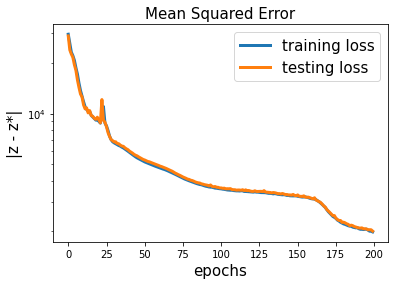

In [ ]:
# ---------------------------------------------
# Plot testing history
# ---------------------------------------------
import matplotlib.pyplot as plt

fig1 = plt.figure(1)
plt.semilogy(train_loss_hist, linewidth=3)
plt.semilogy(test_loss_hist, linewidth=3)
plt.legend(['training loss', 'testing loss'], fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('|z - z*|', fontsize=15)
plt.title('Mean Squared Error', fontsize=15)
plt.savefig('line_plot.pdf')  

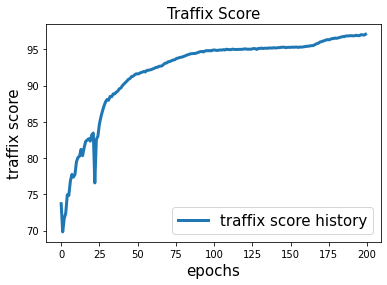

In [ ]:
fig1 = plt.figure(2)
plt.plot(traffix_score_hist, linewidth=3)
plt.legend(['traffix score history'], fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('traffix score', fontsize=15)
plt.title('Traffix Score', fontsize=15)
plt.savefig('traffix_score_plot.pdf')  

### Generate CSV file

In [ ]:
filename = data_set + '_epoch_vs_relerr.csv'
with open(filename, 'w') as f: 
  for epoch, rel_err in enumerate(rel_err_hist):     
    f.write('%0.5e,%0.5e\n' % (epoch + 1, rel_err)) 

filename = data_set + '_epoch_vs_trafix.csv'
with open(filename, 'w') as f: 
  for epoch, traffix_score in enumerate(traffix_score_hist):     
    f.write('%0.5e,%0.5e\n' % (epoch + 1, traffix_score)) 